## Download data first
https://cwfis.cfs.nrcan.gc.ca/downloads/nbac/nbac_1986_to_2022_20230630.zip

Metadata description: 

https://cwfis.cfs.nrcan.gc.ca/downloads/nbac/NBAC_metadata_NAP_ISO_19115_2003.pdf

In [1]:
import pandas as pd
import geopandas as gpd
from pathlib import Path

In [2]:
fires = gpd.read_file('nbac_1986_to_2022_20230630.zip',engine="pyogrio")
fires

/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs

## Data cleaning

In [3]:
# Remove fires without recorded start and end dates
fires = fires[(~fires["SDATE"].isna() &~ fires["EDATE"].isna()) | (~fires["AFSDATE"].isna() & ~fires["AFEDATE"].isna())].reset_index(drop=True)

# Merge two alternative start-end columns
fires["SDATE"] = fires[["SDATE","AFSDATE"]].apply(lambda x: x["SDATE"] if not pd.isnull(x["SDATE"]) else x["AFSDATE"],axis=1)
fires["EDATE"] = fires[["EDATE","AFEDATE"]].apply(lambda x: x["EDATE"] if not pd.isnull(x["EDATE"]) else x["AFEDATE"],axis=1)

# Convert to correct datatype
fires["YEAR"] = fires["YEAR"].apply(lambda x: int(x))
fires["NFIREID"] = fires["NFIREID"].apply(lambda x: int(x))

# Remove initial unnecessary columns
fires = fires[["YEAR","NFIREID","SDATE","EDATE","ADJ_HA","geometry"]]
fires

,YEAR,NFIREID,SDATE,EDATE,ADJ_HA,geometry
0,1986,11,1986-05-21,1986-07-16,54863.753605,"MULTIPOLYGON (((36642.227 250038.703, 36660.83..."
1,1986,40,1986-05-25,1986-07-15,25573.267687,"MULTIPOLYGON (((109825.375 386181.094, 109826...."
2,1986,54,1986-05-22,1986-06-28,4099.013447,"MULTIPOLYGON (((161602.250 461279.438, 161601...."
3,1986,56,1986-05-20,1986-06-27,24515.693098,"MULTIPOLYGON (((131583.766 462159.031, 131613...."
4,1986,71,1986-04-03,1986-04-07,1626.975024,"MULTIPOLYGON (((-487506.988 557033.007, -48750..."
...,...,...,...,...,...,...
20688,2022,1316,2022-10-02,2022-10-02,81.816499,"POLYGON ((-1030078.332 1217836.451, -1030084.0..."
20689,2022,707,2022-09-07,2022-09-10,59.830198,"POLYGON ((-1639662.403 497888.109, -1639662.39..."
20690,2022,1289,2022-05-03,2022-05-03,332.812618,"POLYGON ((-1494058.187 716325.336, -1494058.17..."
20691,2022,1296,2022-06-30,2022-06-30,0.001400,"POLYGON ((-1433731.896 508400.325, -1433732.17..."


In [4]:
# Check for outlier fires going on for a long time
fires["timediff"] = fires.apply(lambda x: x.EDATE - x.SDATE,axis=1)
fires

,YEAR,NFIREID,SDATE,EDATE,ADJ_HA,geometry,timediff
0,1986,11,1986-05-21,1986-07-16,54863.753605,"MULTIPOLYGON (((36642.227 250038.703, 36660.83...",56 days
1,1986,40,1986-05-25,1986-07-15,25573.267687,"MULTIPOLYGON (((109825.375 386181.094, 109826....",51 days
2,1986,54,1986-05-22,1986-06-28,4099.013447,"MULTIPOLYGON (((161602.250 461279.438, 161601....",37 days
3,1986,56,1986-05-20,1986-06-27,24515.693098,"MULTIPOLYGON (((131583.766 462159.031, 131613....",38 days
4,1986,71,1986-04-03,1986-04-07,1626.975024,"MULTIPOLYGON (((-487506.988 557033.007, -48750...",4 days
...,...,...,...,...,...,...,...
20688,2022,1316,2022-10-02,2022-10-02,81.816499,"POLYGON ((-1030078.332 1217836.451, -1030084.0...",0 days
20689,2022,707,2022-09-07,2022-09-10,59.830198,"POLYGON ((-1639662.403 497888.109, -1639662.39...",3 days
20690,2022,1289,2022-05-03,2022-05-03,332.812618,"POLYGON ((-1494058.187 716325.336, -1494058.17...",0 days
20691,2022,1296,2022-06-30,2022-06-30,0.001400,"POLYGON ((-1433731.896 508400.325, -1433732.17...",0 days


In [5]:
# Load Canadian province data

provinces = gpd.read_file("georef-canada-province@public.zip")
print(provinces)
print(f"crs provinces: {provinces.crs}")
print(f"crs fires: {fires.crs}")

    year prov_code                    prov_name_e prov_area_c  \
0   2021    ['48']                    ['Alberta']         CAN   
1   2021    ['60']                      ['Yukon']         CAN   
2   2021    ['46']                   ['Manitoba']         CAN   
3   2021    ['10']  ['Newfoundland and Labrador']         CAN   
4   2021    ['13']              ['New Brunswick']         CAN   
5   2021    ['61']      ['Northwest Territories']         CAN   
6   2021    ['11']       ['Prince Edward Island']         CAN   
7   2021    ['47']               ['Saskatchewan']         CAN   
8   2021    ['59']           ['British Columbia']         CAN   
9   2021    ['12']                ['Nova Scotia']         CAN   
10  2021    ['62']                    ['Nunavut']         CAN   
11  2021    ['35']                    ['Ontario']         CAN   
12  2021    ['24']                     ['Quebec']         CAN   

                 prov_type                prov_name_f  \
0                 province      

In [6]:
provinces = provinces.to_crs(fires.crs)

In [7]:
# Remove fires outside of provinces
province_fires = gpd.sjoin(provinces,gpd.GeoDataFrame(fires,geometry=fires.geometry,crs=provinces.crs),how="right")
fires = province_fires.drop(["index_left","prov_code","prov_name_e","prov_area_c","prov_type","year"],axis=1)
fires

,prov_name_f,YEAR,NFIREID,SDATE,EDATE,ADJ_HA,geometry,timediff
0,Ontario,1986,11,1986-05-21,1986-07-16,54863.753605,"MULTIPOLYGON (((36642.227 250038.703, 36660.83...",56 days
1,Ontario,1986,40,1986-05-25,1986-07-15,25573.267687,"MULTIPOLYGON (((109825.375 386181.094, 109826....",51 days
2,Ontario,1986,54,1986-05-22,1986-06-28,4099.013447,"MULTIPOLYGON (((161602.250 461279.438, 161601....",37 days
3,Ontario,1986,56,1986-05-20,1986-06-27,24515.693098,"MULTIPOLYGON (((131583.766 462159.031, 131613....",38 days
4,Saskatchewan,1986,71,1986-04-03,1986-04-07,1626.975024,"MULTIPOLYGON (((-487506.988 557033.007, -48750...",4 days
...,...,...,...,...,...,...,...,...
20688,Alberta,2022,1316,2022-10-02,2022-10-02,81.816499,"POLYGON ((-1030078.332 1217836.451, -1030084.0...",0 days
20689,Colombie-Britannique,2022,707,2022-09-07,2022-09-10,59.830198,"POLYGON ((-1639662.403 497888.109, -1639662.39...",3 days
20690,Alberta,2022,1289,2022-05-03,2022-05-03,332.812618,"POLYGON ((-1494058.187 716325.336, -1494058.17...",0 days
20691,Alberta,2022,1296,2022-06-30,2022-06-30,0.001400,"POLYGON ((-1433731.896 508400.325, -1433732.17...",0 days


<Axes: >

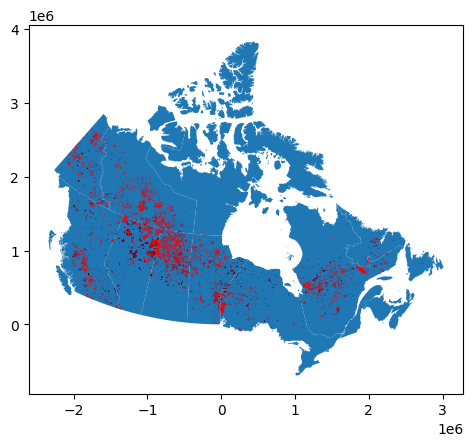

In [8]:
# Visually check distribution of fires
#provinces.plot()
fires[fires["YEAR"] > 2000].plot(ax=provinces.plot(),color='red',marker='x',markersize=3)

In [9]:
## Remove fires going on for more than 3 months (outliers)
print(f" Fires going on for more than 100 days: {len(fires[fires['timediff'].apply(lambda d: d.days) > 100])} of {len(fires)}")
fires = fires[fires['timediff'].apply(lambda d: d.days) > 100]

 Fires going on for more than 100 days: 248 of 20944


In [10]:
## Split fires into per day hectares burnt
fires['day'] = fires.apply(lambda x: pd.date_range(
    x["SDATE"],
    x["EDATE"]
    , freq='D'), axis=1)

fires = fires.explode('day')

fires['ADJ_HA'] = fires.groupby('NFIREID')['ADJ_HA'].transform(lambda x: x/ len(x)).astype(float)
fires

/home/stolpe/Documents/uottawa/DS/Data-Science-Term-Project/ds-project/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,prov_name_f,YEAR,NFIREID,SDATE,EDATE,ADJ_HA,geometry,timediff,day
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-09
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-10
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-11
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-12
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-13
...,...,...,...,...,...,...,...,...,...
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-08
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-09
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-10
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-11


In [12]:
# Convert coordinates of fires to Lat-Lon
from pyproj import Transformer
transformer = Transformer.from_crs(fires.crs, "EPSG:4326")


fire_centroids = fires["geometry"].apply(lambda poly: transformer.transform(poly.centroid.x,poly.centroid.y))
fires[['Latitude', 'Longitude']] = pd.DataFrame(fire_centroids.tolist(), index=fires.index)
fires

,prov_name_f,YEAR,NFIREID,SDATE,EDATE,ADJ_HA,geometry,timediff,day,Latitude,Longitude
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-09,48.859938,-94.592783
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-10,48.859938,-94.592783
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-11,48.859938,-94.592783
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-12,48.859938,-94.592783
32,Ontario,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-13,48.859938,-94.592783
...,...,...,...,...,...,...,...,...,...,...,...
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-08,66.315343,-125.595492
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-09,66.315343,-125.595492
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-10,66.315343,-125.595492
20659,Territoires du Nord-Ouest,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-11,66.315343,-125.595492


In [16]:
# Convert provinces to shortform
prov_short = {'Ontario' : 'ON', 'Manitoba': 'MB', 'Yukon': 'YT', 'Territoires du Nord-Ouest':'NT',
       'Alberta':'AB', 'Saskatchewan':'SK', 'Québec':'QC', 'Colombie-Britannique':'BC',
       'Nouveau-Brunswick':'NB','Terre-Neuve-et-Labrador':'NL','Île-du-Prince-Édouard':'PE','Nouvelle-Écosse':'NS', 'Nunavut':'NU'}


fires['prov_name_f'] = fires["prov_name_f"].map(prov_short)
fires

,prov_name_f,YEAR,NFIREID,SDATE,EDATE,ADJ_HA,geometry,timediff,day,Latitude,Longitude
32,ON,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-09,48.859938,-94.592783
32,ON,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-10,48.859938,-94.592783
32,ON,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-11,48.859938,-94.592783
32,ON,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-12,48.859938,-94.592783
32,ON,1987,5,1987-04-09,1987-10-31,6.659504,"MULTIPOLYGON (((26445.376 -19516.417, 26443.07...",205 days,1987-04-13,48.859938,-94.592783
...,...,...,...,...,...,...,...,...,...,...,...
20659,NT,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-08,66.315343,-125.595492
20659,NT,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-09,66.315343,-125.595492
20659,NT,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-10,66.315343,-125.595492
20659,NT,2022,40,2022-06-21,2022-10-12,0.237407,"POLYGON ((-1280558.230 2200916.001, -1280561.2...",113 days,2022-10-11,66.315343,-125.595492


In [21]:
# Final dropping and renaming of columns
fires = fires.reset_index(drop=True).drop(["YEAR","SDATE","EDATE","geometry","timediff"],axis=1).rename({"prov_name_f":"FireProvinceShort","NFIREID":"BurnIncidentID","ADJ_HA":"HectaresBurnt","Longitude":"FireLongitude","Latitude":"FireLatitude","day":"Date"},axis=1)
fires

,FireProvinceShort,BurnIncidentID,HectaresBurnt,Date,FireLatitude,FireLongitude
0,ON,5,6.659504,1987-04-09,48.859938,-94.592783
1,ON,5,6.659504,1987-04-10,48.859938,-94.592783
2,ON,5,6.659504,1987-04-11,48.859938,-94.592783
3,ON,5,6.659504,1987-04-12,48.859938,-94.592783
4,ON,5,6.659504,1987-04-13,48.859938,-94.592783
...,...,...,...,...,...,...
37776,NT,40,0.237407,2022-10-08,66.315343,-125.595492
37777,NT,40,0.237407,2022-10-09,66.315343,-125.595492
37778,NT,40,0.237407,2022-10-10,66.315343,-125.595492
37779,NT,40,0.237407,2022-10-11,66.315343,-125.595492


In [22]:
# Write to file
fires.to_csv("./firedata_no_station.csv")